In [1]:
import pandas as pd 
import polars as pl
import polars.selectors as cs


In [2]:
df = (
    pl.read_parquet("data/data.parquet")
    # Add datestamp: should be either an integer indexing time or a timestamp
    .with_row_index(name="ds")
    # Fill nulls with 0
    .with_columns((cs.contains("Rate") | cs.contains("Size")).fill_null(0))
    # Basic features
    .with_columns(
        midprice=(pl.col("askRate0") * pl.col("bidRate0")) / 2,
        spread=pl.col("askRate0") - pl.col("bidRate0"),
        skew=pl.col("askSize0").log() - pl.col("bidSize0").log(),
        total_ask_size=pl.sum_horizontal(cs.contains("askSize")),
        total_bid_size=pl.sum_horizontal(cs.contains("bidSize")),
    )
    # Volume-Weighted Average Price (VWAP)
    .with_columns(
        ask_vmap=pl.col('total_ask_size') / pl.sum_horizontal(pl.col(f'askRate{i}') * pl.col(f'askSize{i}') for i in range(15)),
        bid_vmap=pl.col('total_bid_size') / pl.sum_horizontal(pl.col(f'bidRate{i}') * pl.col(f'bidSize{i}') for i in range(15)),
    )
)

In [3]:
data = df.select(["y", "ds"]).with_columns(unique_id=pl.lit("A"))

In [7]:
import pandas as pd
from darts import TimeSeries
from darts.models import StatsForecastAutoETS
from darts.metrics import rmse, r2_score
from darts.utils.statistics import plot_residuals_analysis
from darts.utils.likelihood_models import GaussianLikelihood

series = TimeSeries.from_dataframe(data.head(1000).to_pandas(), time_col="ds", value_cols="y")

# Define hyperparameter grid
param_grid = {
    'season_length': [1, 2, 3],
}

# Perform grid search with temporal cross-validation
gs = StatsForecastAutoETS.gridsearch(
    param_grid,
    series,
    forecast_horizon=100,
    metric=rmse,
    verbose=True,
    n_jobs=10,
)


In [10]:
gs

(StatsForecastAutoETS(add_encoders=None, season_length=1),
 {'season_length': 1},
 0.9047292512697684)

In [14]:
backtest_preds = StatsForecastAutoETS.backtest(
    gs[0],
    series,
    start=0.5,  # Start backtesting from 80% of the series
    forecast_horizon=12,
    metric=[rmse, r2_score]
)

print("In-Sample Metrics (RMSE, R²):", backtest_preds)

# Optional: Plot residuals
residuals = series - gs[0].predict(len(series))
plot_residuals_analysis(residuals)


ValueError: The model must be fit before calling predict(). For global models, if predict() is called without specifying a series, the model must have been fit on a single training series.


In-Sample Metrics (RMSE, R²): [0.30894547       -inf]


ValueError: The model must be fit before calling predict(). For global models, if predict() is called without specifying a series, the model must have been fit on a single training series.

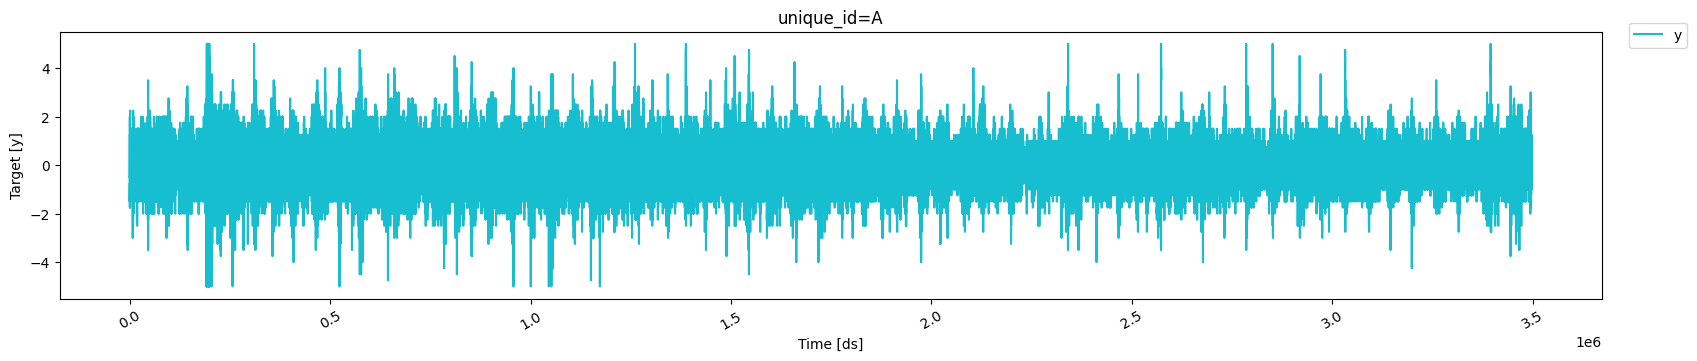

In [4]:
plot_series(data)

In [5]:
from statsforecast.models import AutoETS
from statsforecast import StatsForecast # required to instantiate StastForecast object and use cross-validation method

models = [AutoETS(season_length=1)]

sf = StatsForecast(
    models=models, 
    freq=1, 
    n_jobs=8,
)


In [6]:
cross_sf = sf.cross_validation(
    df=data.head(10000).to_pandas(),
    h=100,
    # We also set step_size equal to the horizon. This parameter controls the distance
    # between each cross-validation window. By setting it equal to the horizon, we perform
    # chained cross-validation where the windows do not overlap.
    step_size=100,
    n_windows=10,
)

/home/pl487/time-series-prediction/.venv/lib/python3.11/site-packages/statsforecast/core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [7]:
cross_sf

,ds,cutoff,y,AutoETS
unique_id,,,,
A,9000,8999,1.5,1.232424
A,9001,8999,1.5,1.232424
A,9002,8999,1.5,1.232424
A,9003,8999,1.5,1.232424
A,9004,8999,1.5,1.232424
...,...,...,...,...
A,9995,9899,1.0,0.499929
A,9996,9899,1.0,0.499929
A,9997,9899,1.0,0.499929


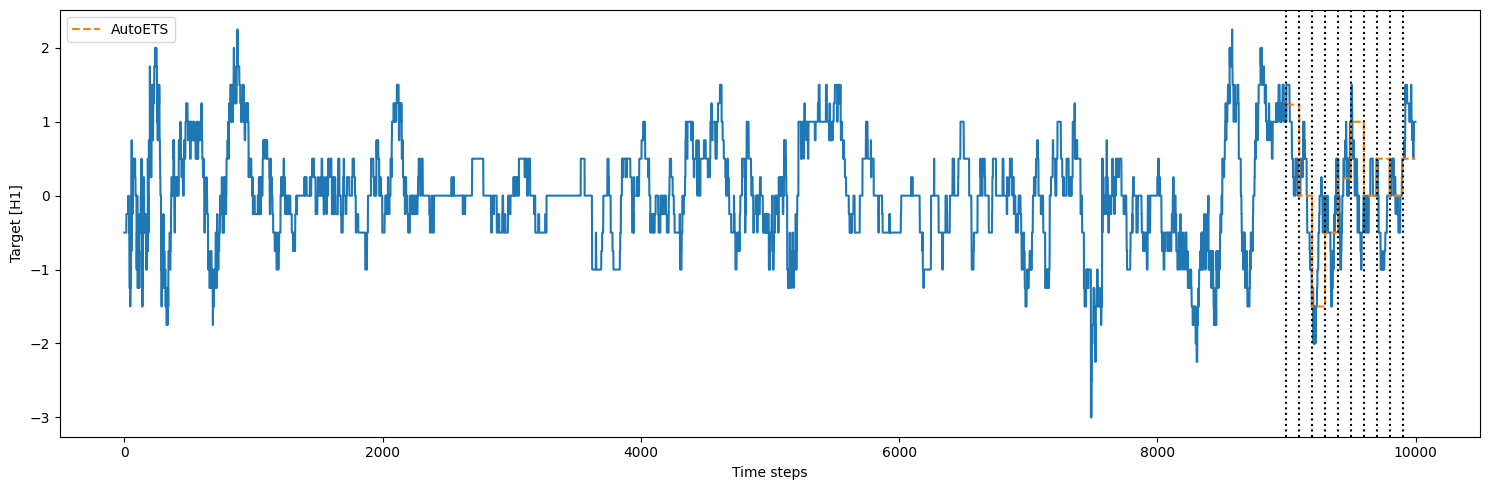

In [8]:
cutoffs = cross_sf['cutoff'].unique()
Y_df = data.head(10000).to_pandas()
import  matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(Y_df['ds'], Y_df['y'])
plt.plot(cross_sf['ds'], cross_sf['AutoETS'], label='AutoETS', ls='--')

for cutoff in cutoffs:
    plt.axvline(x=cutoff, color='black', ls=':')

plt.xlabel('Time steps')
plt.ylabel('Target [H1]')
plt.legend()
plt.tight_layout()



In [9]:
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse, mse


In [ ]:

def mse(
    df: DFType,
    models: List[str],
    id_col: str = "unique_id",
    target_col: str = "y",
) -> DFType:
    """Mean Squared Error (MSE)

    MSE measures the relative prediction
    accuracy of a forecasting method by calculating the
    squared deviation of the prediction and the true
    value at a given time, and averages these devations
    over the length of the series."""
    if isinstance(df, pd.DataFrame):
        res = (
            (df[models].sub(df[target_col], axis=0))
            .pow(2)
            .groupby(df[id_col], observed=True)
            .mean()
        )
        res.index.name = id_col
        res = res.reset_index()
    else:

        def gen_expr(model):
            return pl.col(target_col).sub(pl.col(model)).pow(2).alias(model)

        res = _pl_agg_expr(df, models, id_col, gen_expr)
    return res

In [18]:
cross_sf

,ds,cutoff,y,AutoETS
unique_id,,,,
A,9000,8999,1.5,1.232424
A,9001,8999,1.5,1.232424
A,9002,8999,1.5,1.232424
A,9003,8999,1.5,1.232424
A,9004,8999,1.5,1.232424
...,...,...,...,...
A,9995,9899,1.0,0.499929
A,9996,9899,1.0,0.499929
A,9997,9899,1.0,0.499929


In [23]:
cv_rmse = evaluate(
    cross_sf.reset_index().drop(columns='cutoff'),
    metrics=[rmse, mse],
    agg_fn='mean',
)
cv_rmse

,metric,AutoETS
0,rmse,0.741649
1,mse,0.550043


In [ ]:
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from sklearn.linear_model import LinearRegression

fcst = MLForecast(
    models=LinearRegression(),
    freq=1,  # our serie has a monthly frequency
    lags=[100],
    target_transforms=[Differences([1])],
)
fcst.fit(data)


In [ ]:
preds = fcst.predict(200)
preds


In [ ]:
plot_series(data, preds)

In [ ]:
data

In [ ]:
cv_df = fcst.cross_validation(
    data,
    h=1_000,
    n_windows=10,
    step_size=100_000,
)

In [ ]:
data.join(preds, on=""

In [ ]:
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse

res_rmse = evaluate(
    cv_df.drop(columns='cutoff'),
    metrics=[rmse],
    agg_fn='mean',
)
print(f"RMSE using cross-validation: {cv_rmse['LGBMRegressor'].item():.1f}")
